### Video Captioning

In this exercise, we are going to explore video captioning. We will apply the a simliar techique to what we experimented for image captioning. A feature vector and caption are concatenated to form the input for an RNN. For video, the *mean* of the fc7 feature vector from frames in each video clip is used. The [Microsoft Research Video Description Corpus
(MSVD)](https://www.microsoft.com/en-us/download/details.aspx?id=52422)[2] data set contains roughly 2000 video clips with more than ten captions for each one. 

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import inspect
import time

import numpy as np
import tensorflow as tf
from tensorflow.python.framework import ops
from tensorflow.python.framework import dtypes
#import reader
import collections
import os
import re
import json

import matplotlib.pyplot as plt

from scipy import ndimage
from scipy import misc
import sys
sys.path.insert(0, '/data/models/slim')

slim=tf.contrib.slim
from nets import vgg

from preprocessing import vgg_preprocessing

%matplotlib inline  
!nvidia-smi

Mon Oct 23 07:32:23 2017       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 367.57                 Driver Version: 367.57                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           On   | 0000:00:1E.0     Off |                    0 |
| N/A   38C    P8    31W / 149W |      0MiB / 11439MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

### MSVD Data  
Let's take a look at our data. First, our captions and the video clips they represent. Feel free to change the index that's printed in "(CaptionsandMovies[])" to a different number to explore.

In [2]:
caption_file = open('MSVDCaptions_lower_nochars.txt', 'r') 
data=caption_file.readlines()
caption_file.close()
CaptionsandMovies=[row.split(', ') for row in data]
print(CaptionsandMovies[0])

['mv89psg6zh4_33_46', 'a bird in a sink keeps getting under the running water from a faucet \n']


/data/msvd/frames_224/Hd-NeIhbYGc_43_48
2  frames from this clip are used to train the network
One Frame from clip  Hd-NeIhbYGc_43_48  is displayed below
captions for this clip
['a woman is riding a horse in a pasture \n', 'a woman is riding a horse \n', 'a woman is riding a horse without a saddle \n', 'a woman is riding on a horse \n', 'a young woman is riding a galloping horse \n', 'someone is riding a horse \n', 'the girl rode her horse in the pen \n', 'the woman is riding a horse \n', 'a woman rides a horse \n', 'the girl rode her painted horse \n', 'a girl is riding the horse\n', 'a lady riding a horse\n', 'she is jars raiding\n', 'a girl is riding on a horse \n', 'a girl riding a horse\n', 'a girl riding a horse \n', 'a lady is riding on the horse \n', 'a woman riding a beautiful horse \n', 'a young woman is riding a horse \n', 'silence broken by a whis perd wind\n', 'silence broken by whispered wind video\n', 'the girl rode the painted pony \n']
/data/msvd/frames_224/Hd-NeIhbYGc

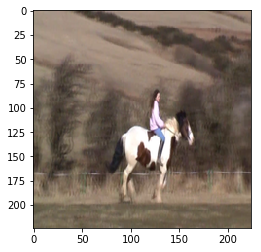

In [4]:
clipnum=0

import os
# getting the frames from a video
from glob import glob
ListofClips = glob('/data/msvd/frames_224/*')
print(ListofClips[clipnum])
clip_frames = [f for f  in os.listdir(ListofClips[0])]
print(len(clip_frames),' frames from this clip are used to train the network')
print('One Frame from clip ',os.path.basename(ListofClips[0]),' is displayed below')
one_image=ndimage.imread(ListofClips[clipnum]+'/'+clip_frames[0])
#resize for vgg network
resize_img=misc.imresize(one_image,[224,224])

#Show image
plt.imshow(resize_img)

#Display Captions for Video clips
MovieCaption=[vid_id[1] for vid_id in CaptionsandMovies if vid_id[0]==ListofClips[clipnum][22:]]
print('captions for this clip')
print(MovieCaption)
clipnum=0

import os
from glob import glob
ListofClips = glob('/data/msvd/frames_224/*')
print(ListofClips[clipnum])
clip_frames = [f for f  in os.listdir(ListofClips[0])]
print(len(clip_frames),' frames from this clip are used to train the network')
print('One Frame from clip ',os.path.basename(ListofClips[0]),' is displayed below')
one_image=ndimage.imread(ListofClips[clipnum]+'/'+clip_frames[0])
#resize for vgg network
resize_img=misc.imresize(one_image,[224,224])

#Show image
plt.imshow(resize_img)

#Display Captions for Video clips
MovieCaption=[vid_id[1] for vid_id in CaptionsandMovies if vid_id[0]==os.path.basename(ListofClips[clipnum])]
print('captions for this clip')
print(MovieCaption)

We'll create a mean vector of a single clip by running each frame through VGG, a pretrained image classification model. This will generate a high-level representation of each frame from layer fc7.

In [5]:
#Create a mean vector of a single video clip 

TRAIN_DATA_PATH='/data/msvd/'
## Read Training files
CLIPOFINTEREST='KpmVL4ANieA_0_9'
one_clip_of_interest = [f for f  in os.listdir(TRAIN_DATA_PATH+'frames_224/'+CLIPOFINTEREST)]
clip_feature_vectors={}
for frame in one_clip_of_interest:   
    tf.reset_default_graph()   
    one_image=ndimage.imread('/data/msvd/frames_224/'+CLIPOFINTEREST+'/'+frame)
    #resize for vgg network
    resize_img=misc.imresize(one_image,[224,224])
    if len(one_image.shape)!= 3: #Check to see if the image is grayscale if True mirror colorband
        resize_img=np.asarray(np.dstack((resize_img, resize_img, resize_img)), dtype=np.uint8)
    #image_size = vgg.vgg_16.default_image_size
    processed_image = vgg_preprocessing.preprocess_image(resize_img, 224, 224, is_training=False)
    processed_images  = tf.expand_dims(processed_image, 0)      
    network,endpts= vgg.vgg_16(processed_images, is_training=False)
   
    init_fn = slim.assign_from_checkpoint_fn(os.path.join('/data/mscoco/vgg_16.ckpt'),slim.get_model_variables('vgg_16'))
    sess = tf.Session()
    init_fn(sess)
    NETWORK,ENDPTS=sess.run([network,endpts])
    sess.close()
    clip_feature_vectors[frame]=ENDPTS['vgg_16/fc7'][0][0][0]


INFO:tensorflow:Restoring parameters from /data/mscoco/vgg_16.ckpt
INFO:tensorflow:Restoring parameters from /data/mscoco/vgg_16.ckpt
INFO:tensorflow:Restoring parameters from /data/mscoco/vgg_16.ckpt
INFO:tensorflow:Restoring parameters from /data/mscoco/vgg_16.ckpt
INFO:tensorflow:Restoring parameters from /data/mscoco/vgg_16.ckpt
INFO:tensorflow:Restoring parameters from /data/mscoco/vgg_16.ckpt
INFO:tensorflow:Restoring parameters from /data/mscoco/vgg_16.ckpt
INFO:tensorflow:Restoring parameters from /data/mscoco/vgg_16.ckpt
INFO:tensorflow:Restoring parameters from /data/mscoco/vgg_16.ckpt
INFO:tensorflow:Restoring parameters from /data/mscoco/vgg_16.ckpt
INFO:tensorflow:Restoring parameters from /data/mscoco/vgg_16.ckpt
INFO:tensorflow:Restoring parameters from /data/mscoco/vgg_16.ckpt
INFO:tensorflow:Restoring parameters from /data/mscoco/vgg_16.ckpt
INFO:tensorflow:Restoring parameters from /data/mscoco/vgg_16.ckpt
INFO:tensorflow:Restoring parameters from /data/mscoco/vgg_16.

In [6]:
numframes=len(clip_feature_vectors.keys())
meanfc7vector=np.zeros([numframes,4096])
for i in range(numframes):
    i=i+1
    meanfc7vector[i-1,:]=clip_feature_vectors['frame_'+'%06d' %i+'_224.bmp'].reshape(1,4096)

meanfc7vector=np.mean(meanfc7vector,axis=0)

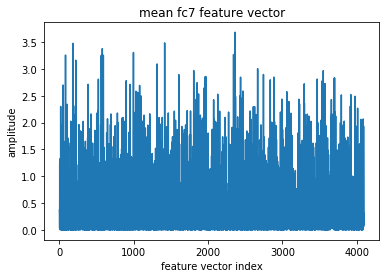

In [7]:
plt.plot(meanfc7vector)
plt.xlabel('feature vector index')
plt.ylabel('amplitude')
plt.title('mean fc7 feature vector')


This should look a lot like the feature vector that we used as context for our RNN for image captioning. To our RNN, it will look identical. Thus, our workflow from this point on mirrors our workflow with images.

See how much you can remember as we recreate it here.

In [8]:
#A npy file of all of the mean feature vectors has been created
file_loader=np.load('/data/msvd/train_msvd_mean_fc7.npy').tolist()
print('Number of videos in the training set: ', len(file_loader.keys()))

Number of videos in the training set:  1773


We are going to align the feature maps with their corresponding captions. A npy file comprised of the mean feature vectors has been created. We will now combine these feature maps with their respective captions.

<button>Hello</button>

In [9]:
#Create 3 lists image_id, feature maps, and captions.
video_id_key=[]
feature_maps_to_id=[]
caption_to_id=[]
for observed_vid in file_loader.keys():   
    for k in range(len(CaptionsandMovies)):
        if CaptionsandMovies[k][0]==observed_vid:
            video_id_key.append([observed_vid])
            feature_maps_to_id.append(file_loader[observed_vid])
            caption_to_id.append(CaptionsandMovies[k][1])
  

print('number of captions  and datapoints',len(caption_to_id))


number of captions  and datapoints 63648


In [10]:
poc=32418
print(video_id_key[poc])
print(feature_maps_to_id[poc])
print(caption_to_id[poc])

['Cx1We6GX4IM_0_8']
[ 0.01285821  1.05511618  2.90329266 ...,  4.96856165  1.45536017
  0.01481449]
a small dog barks and wags his tail 



In [11]:
#Now we will encode our captions and set a dictionary limit

num_steps=20
######################################################################
##Create a list of all of the sentences.
DatasetWordList=[]
for dataset_caption in caption_to_id:
        DatasetWordList+=dataset_caption.split()

#Determine number of distinct words 
distinctwords=collections.Counter(DatasetWordList)
#Order words 
count_pairs = sorted(distinctwords.items(), key=lambda x: (-x[1], x[0])) #ascending order
words, occurence = list(zip(*count_pairs))
DictionaryLength=occurence.index(4) #index for words that occur 4 times or less
words=['PAD','UNK','EOS']+list(words[:DictionaryLength])
word_to_id=dict(zip(words, range(len(words))))
#####################  Tokenize Sentence #######################
Tokenized=[]
for full_words in caption_to_id:
        EmbeddedSentence=[word_to_id[word] for word in full_words.split() if word in word_to_id]+[word_to_id['EOS']]
        #Pad sentences that are shorter than the number of steps 
        if len(EmbeddedSentence)<num_steps:
            b=[word_to_id['PAD']]*num_steps
            b[:len(EmbeddedSentence)]=EmbeddedSentence
        if len(EmbeddedSentence)>num_steps:
            b=EmbeddedSentence[:num_steps]
        if len(b)==EmbeddedSentence:
            b=EmeddedSentence
        b=[word_to_id['UNK'] if x>=DictionaryLength else x for x in b] #turn all words used 4 times or less to 'UNK'
        #print(b)
        Tokenized+=[b]
        
print("Number of words in this dictionary ", len(words))

Number of words in this dictionary  3745


The next two cell are used to configure the RNN and train it to create captions for the video clips. We can use the same model that we used for image captioning. 
   

#### Troubleshooting assistance
Sometimes between training tests error messages like this occur.

#####  "InternalError: Dst tensor is not initialized"  

##### "ResourceExhaustedError: OOM when allocating tensor with shape"

If you receive this you may need to restart your Python kernel, which can be done by going to the Menu bar at the top of this Juptyer Notebook and selecting Kernel then Restart. Remember when restarting the Python kernel, all of your variables will need to be redefined. This will require that you reload the data and tokenize your sentences.  

In [15]:
## Remember that we use the previous words and the feature vector as inputs to predict future words.

def data_queue(TrainingInputs,FeatureVectors):
    train_input_queue = tf.train.slice_input_producer(
                    [TrainingInputs, np.asarray(FeatureVectors)],num_epochs=10000,
                                    shuffle=True) #False before

    ##Set our train data and label input shape for the queue

    TrainingInputs=train_input_queue[0]
    FeatureVectors=train_input_queue[1]
    TrainingInputs.set_shape([num_steps])
    FeatureVectors.set_shape([len(feature_maps_to_id[0])]) #fc7 is 4096
    ##LabelInput.set_shape([num_steps])
    min_after_dequeue=1000000
    capacity = min_after_dequeue + 3 * batch_size 
    #input_x, target_y
    tokenized_caption, input_feature_map = tf.train.batch([TrainingInputs, FeatureVectors],
                                                 batch_size=batch_size,
                                                 capacity=capacity,
                                                 num_threads=6)
    return tokenized_caption, input_feature_map

def rnn_model(Xconcat,input_keep_prob,output_keep_prob,num_layers,num_hidden):
#Create a multilayer RNN
#reuse=False for training but reuse=True for sharing
    layer_cell=[]
    for _ in range(num_layers):
        lstm_cell = tf.contrib.rnn.LSTMCell(num_units=num_hidden, state_is_tuple=True)
        lstm_cell = tf.contrib.rnn.DropoutWrapper(lstm_cell,
                                          input_keep_prob=input_keep_prob,
                                          output_keep_prob=output_keep_prob)
        layer_cell.append(lstm_cell)

    cell = tf.contrib.rnn.MultiRNNCell(layer_cell, state_is_tuple=True)
    outputs, last_states = tf.contrib.rnn.static_rnn(
        cell=cell,
        dtype=tf.float32,
        inputs=tf.unstack(Xconcat))

    output_reshape=tf.reshape(outputs, [batch_size*(num_steps),num_hidden]) #[12==batch_size*num_steps,num_hidden==12]
    pred=tf.matmul(output_reshape, variables_dict["weights_mscoco"]) +variables_dict["biases_mscoco"]
    return pred

Please load the pretrained RNN and finetune. The pretrained network is saved here /data/msvd/video_4096_6model_iter99999

We are going to use the same function we used in the Image Captioning exercise to load our model.

    saver.restore(sess, PRETRAINED_MODEL)

What is the loss?

In [ ]:
tf.reset_default_graph()
#######################################################################################################
# Parameters
num_hidden=4096
num_steps=num_steps
dict_length=len(words)
batch_size=4
num_layers=4
loss_msvd=[]
train_lr=0.0001
#######################################################################################################
TrainingInputs=Tokenized
FeatureVectors=feature_maps_to_id

tokenized_caption, input_feature_map=data_queue(TrainingInputs,FeatureVectors)
## Make Variables    

lr = tf.placeholder(tf.float32, shape=[])
#tf.get_variable_scope().reuse_variables()

variables_dict = {
    "weights_mscoco":tf.Variable(tf.truncated_normal([num_hidden,dict_length],
                                                     stddev=1.0,dtype=tf.float32),name="weights_mscoco"),
    "biases_mscoco": tf.Variable(tf.truncated_normal([dict_length],
                                                     stddev=1.0,dtype=tf.float32), name="biases_mscoco")}


TrainInput=tf.constant(word_to_id['PAD'],shape=[batch_size,1],dtype=tf.int32)
#Pad the beginning of our caption. The first step now only has the image feature vector. Drop the last time step 
#to timesteps to 20
TrainInput=tf.concat([tf.constant(word_to_id['PAD'],shape=[batch_size,1],dtype=tf.int32),
                      tokenized_caption],1)[:,:-1]
X_one_hot=tf.nn.embedding_lookup(np.identity(dict_length), TrainInput) #[batch,num_steps,dictionary_length]
#ImageFeatureTensor=input_feature_map
Xconcat=tf.concat([input_feature_map+tf.zeros([num_steps,batch_size,4096]), 
                                                 tf.unstack(tf.to_float(X_one_hot),num_steps,1)],2)#[:num_steps,:,:]


#the full caption is now the target sentence
y_one_hot=tf.unstack(tf.nn.embedding_lookup(np.identity(dict_length), tokenized_caption),num_steps,1) #[batch,num_steps,dictionary_length]

y_target_reshape=tf.reshape(y_one_hot,[batch_size*num_steps,dict_length])
pred=rnn_model(Xconcat,1.0,1.0,num_layers,num_hidden)

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y_target_reshape))
optimizer = tf.train.AdamOptimizer(learning_rate=lr,epsilon=1.0)


gvs = optimizer.compute_gradients(cost,  aggregation_method = tf.AggregationMethod.EXPERIMENTAL_TREE)
capped_gvs = [(tf.clip_by_value(grad, -10., 10.), var) for grad, var in gvs]
train_op=optimizer.apply_gradients(capped_gvs)

saver = tf.train.Saver()
init_op = tf.group(tf.global_variables_initializer(),
                   tf.local_variables_initializer())    

with tf.Session() as sess:
        
    sess.run(init_op)
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(coord=coord)
    saver.restore(sess, '/data/msvd/video_4096_6model_iter99999')
    for i in range(100):
        
        loss,y_pred,target_caption,_,ftmap=sess.run([cost,pred,tokenized_caption,train_op,input_feature_map],
                                                    feed_dict={lr:train_lr})    

        #print loss
        if i% 10==0:
            print("iteration: ",i, "loss: ",loss)
            
     
    MODEL_NAME='video_4096model_iter'+str(i)
    saver.save(sess, MODEL_NAME)
    print('Saved network ',MODEL_NAME)
    print("Done Training")
    coord.request_stop()
    coord.join(threads)
    sess.close() 


We can use the function below to estimate how well the network is able to predict the next word in the caption. You can evaluate a single image and its caption from the last batch using the index of the batch. If you need a hint look [here](#answer3 "if the batch_size is 4, batch_id may be any value between 0 and 3.").

#### Please note that depending on the status of the neural network at the time it was saved, incomplete, incoherent, and sometimes inappropriate captions can be generated.

In [ ]:
def eval_prediction(batch_id,batch_size,words,target_catpion,predicted_caption, ftmap):
    TARGETSENTENCE=[words[ind] for ind in target_caption[batch_id]]
    PREDICTEDSENTENCE=[words[ind] for ind in np.argmax(y_pred[batch_id::batch_size],1)]
    VIDEOCLIPNAME=[x for x in file_loader.keys() if np.array_equal(ftmap[batch_id],file_loader[x])]
    return TARGETSENTENCE,PREDICTEDSENTENCE, VIDEOCLIPNAME[0]

batch_id=0
t,p,v=eval_prediction(batch_id,batch_size,words,target_caption,y_pred,ftmap)
#print('Ground Truth Words')
#print(t)
print('Predicted Words')
print(p)
exp_image=ndimage.imread('/data/msvd/frames_224/'+v+'/frame_000003_224.bmp')
plt.imshow(exp_image)
plt.title('video clip name:'+v)

##### Questions
[1] Can you load your saved network and use it to generate a caption from a validation image like we did in the image captioning section?

A npy file of the feature vectors from the validation dataset is stored /data/msvd/val_msvd_mean_fc7.npy. If you need help please look [here](#answer4 "Replace ##FIXME## with  /data/msvd/val_msvd_mean_fc7.npy"). 


Then load the pretrained network that was just created and use it to generate a caption for a validation clip. A video clip can be tested with the VALDATA variable. If you need a hint look [here](#answer5 "VALDATA represents the index of a clip you are interested in generating a caption for, any value between 0 and 196 can be used. For example you could set this variable to zero, VALDATA=0. The network saved in the previous cell is video_4096model_iter99. The name of the file is used with saver.restore(sess, MODEL_NAME)").

[2] Do you need to calculate the loss or cost when only performing inference?

[3] Do you use dropout when performing inference?

In [ ]:
#A npy file of all of the mean feature vectors has been created
val_loader=np.load('/data/msvd/val_msvd_mean_fc7.npy').tolist()
print('Number of videos in the validation set: ', len(val_loader.keys()))
#Create 2 lists one of the video_id and the other with feature maps.
val_id_key=[]
val_maps_to_id=[]

for observed_vid in val_loader.keys():   
        val_id_key.append([observed_vid])
        val_maps_to_id.append(val_loader[observed_vid])
  
print('number of captions and datapoints',len(val_maps_to_id))

In [ ]:
tf.reset_default_graph()
batch_size=1
num_steps=20
print_topn=0 #0for do not display 
printnum0f=3
#Choose a image to caption
VALDATA=##FIXME## #Val Video Id

variables_dict = {
    "weights_mscoco":tf.Variable(tf.truncated_normal([num_hidden,dict_length],
                                                     stddev=1.0,dtype=tf.float32),name="weights_mscoco"),
    "biases_mscoco": tf.Variable(tf.truncated_normal([dict_length],
                                                     stddev=1.0,dtype=tf.float32), name="biases_mscoco")}


StartCaption=np.zeros([batch_size,num_steps],dtype=np.int32).tolist()

CaptionPlaceHolder = tf.placeholder(dtype=tf.int32, shape=(batch_size , num_steps))

ValFeatureMap=val_maps_to_id[VALDATA]
X_one_hot=tf.nn.embedding_lookup(np.identity(dict_length), CaptionPlaceHolder) #[batch,num_steps,dictionary_length]
    #ImageFeatureTensor=input_feature_map
Xconcat=tf.concat([ValFeatureMap+tf.zeros([num_steps,batch_size,4096]), 
                            tf.unstack(tf.to_float(X_one_hot),num_steps,1)],2)#[:num_steps,:,:]

pred=rnn_model(Xconcat,1.0,1.0,num_layers,num_hidden)
pred=tf.nn.softmax(pred)
saver = tf.train.Saver()

init_op = tf.group(tf.global_variables_initializer(),tf.local_variables_initializer())    

with tf.Session() as sess:
        
    sess.run(init_op)
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(coord=coord)
    #Load a pretrained network
    saver.restore(sess, '##FIXME##')
    print('Model restored from file')
    for i in range(num_steps-1):
        predict_next_word=sess.run([pred],feed_dict={CaptionPlaceHolder:StartCaption})
        INDEX=np.argmax(predict_next_word[0][i])
        StartCaption[0][i+1]=INDEX
        if print_topn !=0:
            print("Top ",str(printnum0f), "predictions for the", str(i+1), "word in the predicted caption" )
            result_args = np.argsort(predict_next_word[0][i])[-printnum0f:][::-1]
            NextWord=[words[x] for x in result_args]
            print(NextWord)
        
    coord.request_stop()
    coord.join(threads)
    sess.close() 

#print("ground truth caption: ",val_caption_to_id[VALDATA])
v=val_id_key[VALDATA][0]
img=ndimage.imread('/data/msvd/frames_224/'+v+'/frame_000003_224.bmp')
plt.imshow(img)
PredictedCaption=[words[x] for x in StartCaption[0]]

print("predicted sentence: ",PredictedCaption[1:])

How'd you do?

At this point, you know how to use Deep Learning and TensorFlow to generate and use an understanding of visual and textual data. From this point, you can experiment to improve performance or begin to research different ways in which you can use what you've learned. Can't wait to see what you do with it!

Feel free to download these notebooks to continue to learn.

In [ ]:
#Free our GPU memory before proceeding to other parts of the lab
# import os
# os._exit(00)

## References 
[1] Venugopalan, S., et al. "Translating videos to natural language using deep recurrent neural networks." arXiv preprint arXiv:1412.4729 (2014).

[2] Chen, David L., and William B. Dolan. "Collecting highly parallel data for paraphrase evaluation." Proceedings of the 49th Annual Meeting of the Association for Computational Linguistics: Human Language Technologies-Volume 1. Association for Computational Linguistics, 2011.
